goal 
- implement convolutional GP
    - interdomain inducing points in patch space
    - rectangles dataset

In [1]:

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['TF_CPP_VMODULE'] = '=bfc_allocator=1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/local/cuda'
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
os.environ['LD_LIBRARY_PATH'] = '${LD_LIBRARY_PATH}:/usr/local/cuda/lib64'

import jax
import jax.numpy as np
from jax import grad, jit, vmap, device_put, random
from flax import linen as nn

from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
print(jax.local_device_count())
print(jax.devices())

import time

import numpy as onp
onp.set_printoptions(precision=3,suppress=True)
import matplotlib.pyplot as plt

import tensorflow as tf


from plt_utils import *
from gpax import *

gpu
1
[GpuDevice(id=0)]


(10, 196) (10, 1) <class 'jax.interpreters.xla.DeviceArray'>
(10, 196) (10, 1)


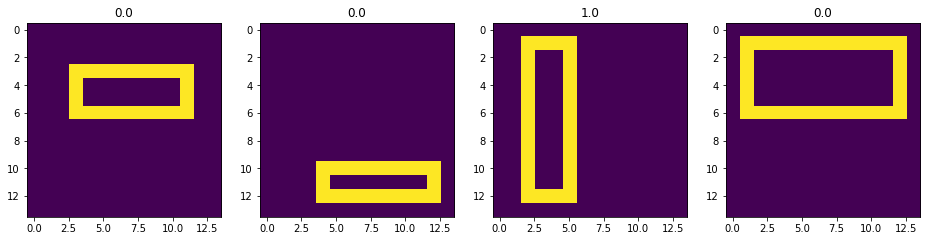

In [27]:
def make_rectangle(arr, x0, y0, x1, y1):
    arr[y0:y1, x0] = 1
    arr[y0:y1, x1] = 1
    arr[y0, x0:x1] = 1
    arr[y1, x0 : x1 + 1] = 1


def make_random_rectangle(arr):
    x0 = onp.random.randint(1, arr.shape[1] - 3)
    y0 = onp.random.randint(1, arr.shape[0] - 3)
    x1 = onp.random.randint(x0 + 2, arr.shape[1] - 1)
    y1 = onp.random.randint(y0 + 2, arr.shape[0] - 1)
    make_rectangle(arr, x0, y0, x1, y1)
    return x0, y0, x1, y1


def make_rectangles_dataset(num, w, h):
    d, Y = onp.zeros((num, h, w)), onp.zeros((num, 1))
    for i, img in enumerate(d):
        for j in range(1000):  # Finite number of tries
            x0, y0, x1, y1 = make_random_rectangle(img)
            rw, rh = y1 - y0, x1 - x0
            if rw == rh:
                img[:, :] = 0
                continue
            Y[i, 0] = rw > rh
            break
    return (
        d.reshape(num, w * h).astype(onp.float32),
        Y.astype(onp.float32),
    )


## Data

onp.random.seed(123)
key = random.PRNGKey(0)

MAXITER = 2 # 100
NUM_TRAIN_DATA = 10 # 100
NUM_TEST_DATA = 10 # 300
H = W = 14  # width and height. In the original paper this is 28
h = w = 14
IMAGE_SHAPE = [H, W]


X, Y = make_rectangles_dataset(NUM_TRAIN_DATA, *IMAGE_SHAPE)
Xt, Yt = make_rectangles_dataset(NUM_TEST_DATA, *IMAGE_SHAPE)
X, Y, Xt, Yt = np.array(X), np.array(Y), np.array(Xt), np.array(Yt)
data = (X,Y); test_data = (Xt,  Yt)


print(X.shape, Y.shape, type(X))
print(Xt.shape, Yt.shape)

plt.figure(figsize=(16, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(X[i, :].reshape(*IMAGE_SHAPE))
    plt.title(Y[i, 0])
    

In [3]:


class CNN(nn.Module):
    """A simple CNN model."""
    output_dim: int = 2

    @nn.compact
    def __call__(self, x):
        x = x.reshape(-1, *IMAGE_SHAPE, 1)
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(features=self.output_dim)(x)
        x = nn.log_softmax(x)
        return x
    
class CNNTrunk(nn.Module):

    @nn.compact
    def __call__(self, x):
        x = x.reshape(-1, *IMAGE_SHAPE, 1)
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))
        x = nn.Dense(features=128)(x)
        return x
    
    

def cross_entropy_loss(logits, labels):
    y_onehot = jax.nn.one_hot(labels, num_classes=output_dim).squeeze()
    return -np.mean(np.sum(y_onehot * logits, axis=-1))


def compute_metrics(logits, labels):
    loss = cross_entropy_loss(logits, labels)
    pred = np.argmax(logits, -1).reshape(-1,1)
    accuracy = np.mean(pred == labels)
    metrics = {'loss': loss,
               'accuracy': accuracy}
    return metrics


@jax.jit
def train_step(opt, batch, key):
    key, subkey = random.split(key)
    X, y = batch
    def loss_fn(params):
        logits = CNN(output_dim=output_dim).apply(params, X)
        loss = cross_entropy_loss(logits, y)
        return loss, logits
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grad = grad_fn(opt.target)
    opt = opt.apply_gradient(grad)
    metrics = compute_metrics(logits, y)
    log = {'loss': loss,
           'accuracy': metrics['accuracy'],
           'dense0_kernel_gradnorm': linalg.norm(grad['params']['Dense_0']['kernel'])}
    return opt, log, key


@jax.jit
def eval_step(params, X):
    logits = CNN(output_dim=output_dim).apply(params, X)
    return logits


def eval_model(params, data_test, logit_fn=eval_step):
    test_n_batches, test_batches = get_data_stream(
        random.PRNGKey(0), 100, data_test)

    logits = []; labels = []
    for _ in range(test_n_batches):
        batch = next(test_batches)
        X, y = batch
        logit = logit_fn(params, X)
        labels.append(y.reshape(-1, 1))
        logits.append(logit)

    logits = np.vstack(logits)
    labels = np.vstack(labels)
    metrics = compute_metrics(logits, labels)
    metrics = jax.tree_map(lambda x: x.item(), metrics)
    return metrics


In [30]:
model = CNN(output_dim=output_dim)
params = model.init(key, np.ones((1,28,28,1)))
opt = flax_create_optimizer(params, 'Adam', {'learning_rate': .03})

metrics = eval_model(params, test_data)
print(f'[{0:3}] test \t'
      f'Loss={metrics["loss"]:.3f}\t'
      f'accuracy={metrics["accuracy"]:.3f}\t')


from collections import defaultdict
bsz = 64
train_n_batches, train_batches = get_data_stream(key, bsz, data)
n_epochs = 20

for epoch in range(n_epochs):
    logs = defaultdict(list)
    for it in range(train_n_batches):
        step = epoch*train_n_batches+it
        batch = next(train_batches)
        opt, log, key = train_step(opt, batch, key)
        params = opt.target
        for k, v in log.items():
            logs[k].append(v)
        if step%(train_n_batches)==0:
            avg_metrics = {k: np.mean(np.array(v))
                           for k, v in logs.items()}
            print(f'[{epoch:3}|{100*it/train_n_batches:5.2f}%]\t'
                  f'Loss={avg_metrics["loss"]:.3f}\t'
                  f'accuracy={avg_metrics["accuracy"]:.3f}\t')
    
    metrics = eval_model(params, test_data)
    print(f'[{epoch:3}] test \t'
          f'Loss={metrics["loss"]:.3f}\t'
          f'accuracy={metrics["accuracy"]:.3f}\t')
    
    
cnn_save_path = f'./cnn_params_rectangle.pkl'
pytree_save(opt.target, cnn_save_path)
params = pytree_load(CNN(output_dim=output_dim).init(key, np.ones((1,28,28,1))), cnn_save_path)

metrics = eval_model(params, test_data)
print(f'Loss={metrics["loss"]:.3f}\t'
      f'accuracy={metrics["accuracy"]:.3f}\t')

[  0] test 	Loss=0.687	accuracy=0.610	
[  0| 0.00%]	Loss=0.686	accuracy=0.625	
[  0] test 	Loss=1.187	accuracy=0.460	
[  1| 0.00%]	Loss=1.289	accuracy=0.406	
[  1] test 	Loss=0.694	accuracy=0.520	
[  2| 0.00%]	Loss=0.669	accuracy=0.562	
[  2] test 	Loss=0.683	accuracy=0.520	
[  3| 0.00%]	Loss=0.641	accuracy=0.578	
[  3] test 	Loss=0.707	accuracy=0.520	
[  4| 0.00%]	Loss=0.647	accuracy=0.531	
[  4] test 	Loss=0.660	accuracy=0.520	
[  5| 0.00%]	Loss=0.608	accuracy=0.562	
[  5] test 	Loss=0.628	accuracy=0.720	
[  6| 0.00%]	Loss=0.507	accuracy=0.797	
[  6] test 	Loss=0.492	accuracy=0.830	
[  7| 0.00%]	Loss=0.338	accuracy=0.875	
[  7] test 	Loss=0.358	accuracy=0.830	
[  8| 0.00%]	Loss=0.266	accuracy=0.875	
[  8] test 	Loss=0.621	accuracy=0.740	
[  9| 0.00%]	Loss=0.197	accuracy=0.938	
[  9] test 	Loss=0.583	accuracy=0.780	
[ 10| 0.00%]	Loss=0.439	accuracy=0.844	
[ 10] test 	Loss=0.906	accuracy=0.730	
[ 11| 0.00%]	Loss=0.206	accuracy=0.922	
[ 11] test 	Loss=0.231	accuracy=0.910	
[ 12| 0.00%]	

In [37]:
output_dim = 2
α_ϵ = 1; α_δ = 10; n_mc_samples = 20; n_inducing = 10
patch_size = (3,3)

lik_type = 'LikMulticlassSoftmax' # LikMulticlassDirichlet, LikMulticlassSoftmax, LikMultipleNormalKron
init_val_m = gamma_to_lognormal(np.array([1.]))[0] \
    if lik_type == 'LikMulticlassDirichlet' else np.array([.5])
mean_fn_cls = partial(MeanConstant,
                      output_dim=output_dim,
                      init_val_m=init_val_m,
                      flat=False)
if lik_type == 'LikMulticlassDirichlet':
    lik_cls = partial(LikMulticlassDirichlet,
                      output_dim=output_dim,
                      init_val_α_ϵ=α_ϵ,
                      init_val_α_δ=α_δ,
                      n_mc_samples=n_mc_samples)
elif lik_type == 'LikMulticlassSoftmax':
    lik_cls = partial(LikMulticlassSoftmax,
                      output_dim=output_dim,
                      n_mc_samples=n_mc_samples)
else:
    lik_cls = partial(LikMultipleNormalKron,
                      output_dim=output_dim)
    
# previous
g_cls = LayerIdentity # CNNTrunk
# kx_cls = partial(CovSE, output_scaling=True)
kx_cls = partial(CovConvolutional, image_size=(H,W,1), patch_size=patch_size, kg_cls=CovSE)
k_cls = partial(CovMultipleOutputIndependent,
                k_cls=kx_cls,
                output_dim=output_dim,
                g_cls=g_cls)

Xu_initial = X[np.linspace(0,len(X)-1,n_inducing).astype(np.int32)].copy()
Xp_initial = extract_patches_2d_vmap(X.reshape(-1, H, W), patch_size).reshape(-1, 9)
Xp_initial = np.array(onp.unique(Xp_initial, axis=0))
inducing_loc_cls = partial(InducingLocations,
                           shape=(n_inducing, 196),
                           init_fn_inducing=lambda k,s: Xu_initial)

model = SVGP(mean_fn_cls=mean_fn_cls,
             k_cls=k_cls,
             lik_cls=lik_cls,
             inducing_loc_cls=inducing_loc_cls,
             n_data=len(X),
             output_dim=output_dim)


params = model.get_init_params(model, key)
params

FrozenDict({'params': {'mean_fn': {'c': DeviceArray([0.5, 0.5], dtype=float32)}, 'k': {'ks_0': {'kg': {'ls': DeviceArray([0.541], dtype=float32), 'σ2': DeviceArray([0.541], dtype=float32)}}, 'ks_1': {'kg': {'ls': DeviceArray([0.541], dtype=float32), 'σ2': DeviceArray([0.541], dtype=float32)}}}, 'Xu': {'X': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)}, 'q': {'μ': DeviceArray([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32), 'L': DeviceArray([[1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
              0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
              0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
             [

In [38]:
# load pretrained weights & set initial values
if g_cls != LayerIdentity:
    encoder_params = pytree_load({'params': params['params']['k']['g']}, cnn_save_path)
    encoder_params_kvs = pytree_get_kvs(encoder_params)
    params = pytree_mutate(params, {f'params/k/g/{k}': v for k,v in encoder_params_kvs.items()})
params = pytree_mutate(params, {f'params/k/ks_{i}/ls': softplus_inv(np.array([2.]))
                                for i in range(output_dim)})

kwd_notrain = ['mean_fn', 'Xu/X']
kwd_trainslow = [] # Xu/T
params_wrap = flax_params2model(model, params)
opt = flax_create_multioptimizer(
    params_wrap, 'Adam',
    [{'learning_rate': 0.}, {'learning_rate': .01}, {'learning_rate': .03}],
    [lambda p, v: pytree_path_contains_keywords(p, kwd_notrain),
     lambda p, v: pytree_path_contains_keywords(p, kwd_trainslow),
     lambda p, v: not pytree_path_contains_keywords(p, kwd_notrain+kwd_trainslow)])

flax_check_multiopt(params_wrap, opt)
# params

_AdamHyperParams(learning_rate=0.0, beta1=0.9, beta2=0.999, eps=1e-08, weight_decay=0.0)
['/params/Xu/X', '/params/mean_fn/c']
_AdamHyperParams(learning_rate=0.01, beta1=0.9, beta2=0.999, eps=1e-08, weight_decay=0.0)
['/params/k/ks_0/kg/ls', '/params/k/ks_0/kg/σ2', '/params/k/ks_1/kg/ls', '/params/k/ks_1/kg/σ2']
_AdamHyperParams(learning_rate=0.03, beta1=0.9, beta2=0.999, eps=1e-08, weight_decay=0.0)
['/params/q/L', '/params/q/μ']


In [ ]:
######################################################
import time
        
@jax.jit
def eval_model(params):
    Xt, Yt = test_data
    Ey, Vy = model.apply(params, Xt, method=model.pred_y, rngs={'lik_mc_samples': key})
    pred = np.argmax(Ey, -1).reshape(-1, 1)
    acc = np.mean(pred == Yt)
    return acc

@jax.jit
def train_step2(step, opt, batch, key):
    key, subkey = random.split(key)
    Xb, yb = batch
    y_onehot = jax.nn.one_hot(yb.squeeze(), num_classes=output_dim).reshape((-1,output_dim))
    def loss_fn(params):
        fx = model.apply(params,
                         (Xb, y_onehot),
                         method=model.mll,
                         rngs={'lik_mc_samples': subkey})
        return -fx, {}
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    params = flax_model2params(opt.target)
    (loss, aux), grad = grad_fn(params)
    opt = opt.apply_gradient(flax_params2model(model, grad))
    insert_str = '/kg' if isinstance(model.k_cls().k_cls(), CovConvolutional) else ''
    log = {'loss': loss,
           'k.ls': jax.nn.softplus(pytree_leaf(params, f'params/k/kx/ls')
                                   if isinstance(model.k_cls(), CovICM) else 
                                   np.hstack([pytree_leaf(params, f'params/k/ks_{i}{insert_str}/ls')
                                              for i in range(output_dim)])),
           'k.σ2': jax.nn.softplus(pytree_leaf(params, f'params/k/kx/σ2')
                                   if isinstance(model.k_cls(), CovICM) else 
                                   np.hstack([pytree_leaf(params, f'params/k/ks_{i}{insert_str}/σ2')
                                              for i in range(output_dim)]))}
    return opt, log, key


bsz = 3
train_n_batches, train_batches = get_data_stream(key, bsz, data)

n_epochs = 30

for epoch in range(n_epochs):
    start = time.time()
    for it in range(train_n_batches):
        step = epoch*train_n_batches+it
        batch = next(train_batches)
        opt, log, key = train_step2(step, opt, batch, key)
        params = flax_model2params(opt.target)
        if step%(train_n_batches*n_epochs//30)==0:
            acc = eval_model(params)
            print(f'[{epoch:3}|{100*it/train_n_batches:5.2f}%]\t'
                  f'Time={time.time()-start:.3f}\t'
                  f'Loss={log["loss"]:.3f}\t'
                  f'k.ls={log["k.ls"][:3]}\t'
                  f'k.σ2={log["k.σ2"][:3]}\t'
                  f'acc={acc:.3f}\t')
            start = time.time()


params = flax_model2params(opt.target)


# acc
# pretrained cnntrunk: .96 (bsz=5, n_inducing=50%)
# just rbf kernel: .63
# convolutional with rbf base kernel: 

[  0| 0.00%]	Time=116.617	Loss=33568.738	k.ls=[1. 1.]	k.σ2=[1. 1.]	acc=0.700	


In [7]:
from typing import Any, Callable, Sequence, Optional, Tuple, Union, List, Iterable


class CovConvolutional(Kernel):
    """ Convolutional Kernel f~GP(0,k)
            where k(x,x') = ΣpΣp' kᵧ(X[p], X[p'])
                  kᵧ(z,z') is the patch kernel
    """
    image_size: Tuple[int] = (28, 28, 1) # (H, W, C)
    patch_size: Tuple[int] = (3, 3)      # (h, w)
    kg_cls: Callable = CovSE

    def setup(self):
        self.kg = self.kg_cls()
    
    def kp(self, Xp, Yp, full_cov):
        """ Computes yet-to-be summed kernel `self.kg`

            Xp    (N, P, h, w)
            Yp    (M, P, h, w)
            Returns
                (N, P, M, P) if `Yp` not None 
                    Computes K(X,Y)
                (N, P, P) if `Yp` is None
                    Computes K(X)
        """
        if full_cov:
            Xp_shape = Xp.shape # (N, P, h, w)
            Xp = Xp.reshape(-1, self.patch_len) # (N*P, h*w)
            Yp_shape = Yp.shape if Yp is not None else Xp_shape # (M, P, h, w)
            Yp = Yp.reshape(-1, self.patch_len) if Yp is not None else Yp # (M*P, h*w)
            Kp = self.kg(Xp, Yp, full_cov=full_cov) # (N*P, M*P)
            Kp = Kp.reshape(Xp_shape[:2]+Yp_shape[:2]) # (N, P, M, P)
        else:
            Xp_shape = Xp.shape
            Xp = Xp.reshape((Xp_shape[0], Xp_shape[1], -1)) # (N, P, h*w)
            Kp = vmap(self.kg, (0, None, None), 0)(Xp, None, True) # (N, P, P)
        return Kp
        
    def get_patches(self, X):
        """ (N, H, W, 1) -> # (N, P, h, w) where P=#patches """
        patches = extract_patches_2d_vmap(X.reshape((-1, *self.image_size)),
                                          self.patch_size)
        if patches.shape[1] != self.num_patches:
            raise ValueError('#patches extracted not correct')
        return patches

    def K(self, X, Y=None):
        Xp = self.get_patches(X)
        Yp = None if Y is None else self.get_patches(Y)
        Kp = self.kp(Xp, Yp, full_cov=True)
        K = np.mean(Kp, axis=[1, 3])
        return K

    def Kdiag(self, X, Y=None):
        Xp = self.get_patches(X)
        Kp = self.kp(Xp, None, full_cov=False)
        K = np.mean(Kp, axis=[1, 2])
        return K

    @property
    def patch_len(self):
        return self.patch_size[0]*self.patch_size[1]
    
    @property
    def num_patches(self):
        H, W, C = self.image_size
        h, w = self.patch_size
        return (H-h+1)*(W-w+1)*C
    
    
    
    
# x = random.normal(key, (4,14,14,1))
# y = random.normal(key, (5,14,14,1))
# k = CovConvolutional(image_size=(14,14,1), patch_size=(3,3))
# params = k.init(key, x)
# K = k.apply(params, x, full_cov=False)
# K


DeviceArray([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 1.],
             [0., 0., 0., 0., 0., 0., 0., 1., 1.],
             [0., 0., 0., 0., 0., 0., 1., 0., 0.],
             [0., 0., 0., 0., 0., 0., 1., 1., 0.],
             [0., 0., 0., 0., 0., 0., 1., 1., 1.],
             [0., 0., 0., 0., 0., 1., 0., 0., 1.],
             [0., 0., 0., 0., 1., 1., 0., 1., 0.],
             [0., 0., 0., 1., 0., 0., 1., 0., 0.],
             [0., 0., 0., 1., 1., 0., 0., 1., 0.],
             [0., 0., 0., 1., 1., 1., 0., 0., 0.],
             [0., 0., 0., 1., 1., 1., 0., 0., 1.],
             [0., 0., 0., 1., 1., 1., 1., 0., 0.],
             [0., 0., 0., 1., 1., 1., 1., 0., 1.],
             [0., 0., 1., 0., 0., 0., 0., 0., 0.],
             [0., 0., 1., 0., 0., 1., 0., 0., 0.],
             [0., 0., 1., 0., 0., 1., 0., 0., 1.],
             [0., 0., 1., 0., 0., 1., 1., 1., 1.],
             [0., 0., 1., 1., 1., 1., 0., 0., 0.],
             [0., 1., 0., 0., 1